In [491]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# Cargar los datos desde el archivo Excel
data = pd.read_excel('C:/Users/User/Desktop/prueba payu/Base Prueba.xlsx')
Data=pd.DataFrame(data)
# Mostrar el DataFrame original
print(Data)

        identificador cliente nombre cliente       Date  Cost USD  \
0                   510555613      AAAABBB-1 2022-05-01  35594973   
1                   510555613      AAAABBB-1 2022-06-01  49072039   
2                   510555613      AAAABBB-1 2022-09-01  65343219   
3                   510555613      AAAABBB-1 2022-11-01   6366652   
4                   510555617      AAAABBB-2 2022-04-01  87555273   
...                       ...            ...        ...       ...   
183798              511142295  AAAABBB-28254 2023-03-01  50221115   
183799              511143072  AAAABBB-28255 2023-03-01  32491129   
183800              510962869  AAAABBB-28256 2023-03-01  78734102   
183801              510715383  AAAABBB-28257 2023-03-01  16086065   
183802              511142232  AAAABBB-28258 2023-03-01  23278147   

        Financing Costs  Anticipation cost  Validation Costs  Rev Tax cost  \
0              80542247           29805489          13867748      76910407   
1              

In [532]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
Data['YearMonth'] = Data['Date'].dt.to_period('M')
monthly_avg_sales = Data.groupby('YearMonth')['Sales'].mean().reset_index()
# Convertir la Serie a un DataFrame
result_df = monthly_avg_sales.reset_index()

# Imprimir el DataFrame resultante
print(result_df)

    index YearMonth          Sales
0       0   2022-04 1034354768.163
1       1   2022-05 1042972672.508
2       2   2022-06 1039630025.602
3       3   2022-07 1044971422.117
4       4   2022-08 1043180325.251
5       5   2022-09 1052538185.814
6       6   2022-10 1044756459.951
7       7   2022-11 1036178857.317
8       8   2022-12 1047175390.280
9       9   2023-01 1034991819.799
10     10   2023-02 1038707406.033
11     11   2023-03 1034524127.425


In [533]:


result_df['cambio_valor'] = result_df['Sales'].diff()
result_df['cambio_porcentual'] = result_df['Sales'].pct_change() * 100
print(result_df)

    index YearMonth          Sales  cambio_valor  cambio_porcentual
0       0   2022-04 1034354768.163           NaN                NaN
1       1   2022-05 1042972672.508   8617904.345              0.833
2       2   2022-06 1039630025.602  -3342646.906             -0.320
3       3   2022-07 1044971422.117   5341396.515              0.514
4       4   2022-08 1043180325.251  -1791096.867             -0.171
5       5   2022-09 1052538185.814   9357860.563              0.897
6       6   2022-10 1044756459.951  -7781725.863             -0.739
7       7   2022-11 1036178857.317  -8577602.635             -0.821
8       8   2022-12 1047175390.280  10996532.964              1.061
9       9   2023-01 1034991819.799 -12183570.481             -1.163
10     10   2023-02 1038707406.033   3715586.234              0.359
11     11   2023-03 1034524127.425  -4183278.608             -0.403


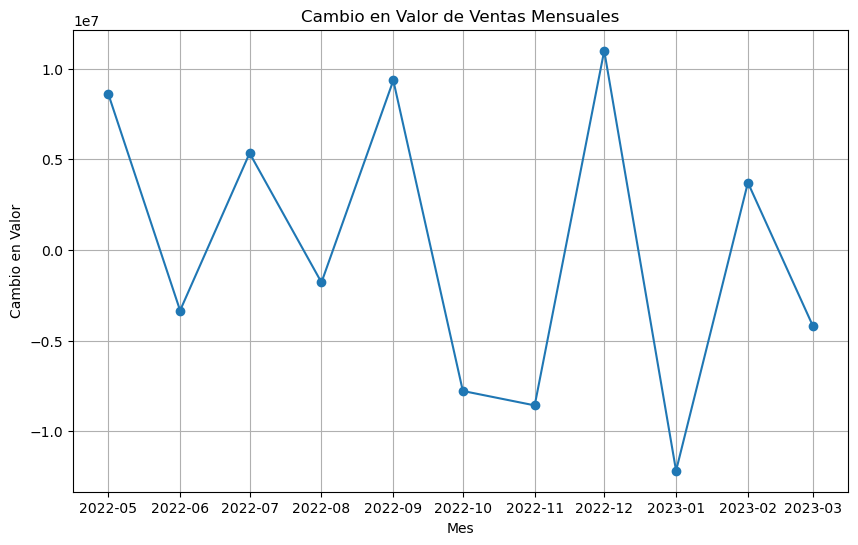

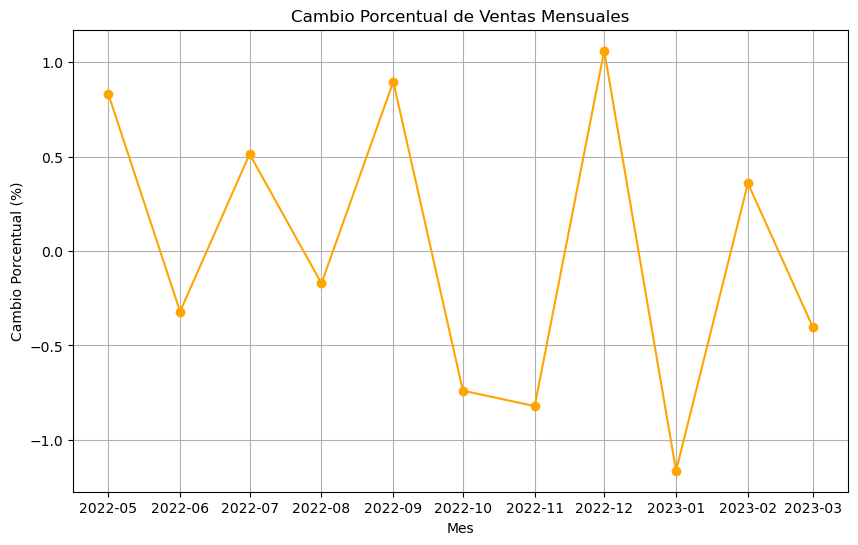

In [534]:
result_df['YearMonth'] = pd.to_datetime(result_df['YearMonth'].astype(str), format='%Y-%m')
result_df['YearMonth'] = pd.to_datetime(result_df['YearMonth'], format='%Y-%m')
#primer punto
# Visualizar el cambio en valor
plt.figure(figsize=(10, 6))
plt.plot(result_df['YearMonth'], result_df['cambio_valor'], marker='o')
plt.title('Cambio en Valor de Ventas Mensuales')
plt.xlabel('Mes')
plt.ylabel('Cambio en Valor')
plt.grid(True)
plt.show()

# Visualizar el cambio porcentual
plt.figure(figsize=(10, 6))
plt.plot(result_df['YearMonth'], result_df['cambio_porcentual'], marker='o', color='orange')
plt.title('Cambio Porcentual de Ventas Mensuales')
plt.xlabel('Mes')
plt.ylabel('Cambio Porcentual (%)')
plt.grid(True)
plt.show()



0    1034354768.163
1    1042972672.508
2    1039630025.602
3    1044971422.117
4    1043180325.251
5    1052538185.814
6    1044756459.951
7    1036178857.317
8    1047175390.280
9    1034991819.799
10   1038707406.033
11   1034524127.425
Name: Sales, dtype: float64


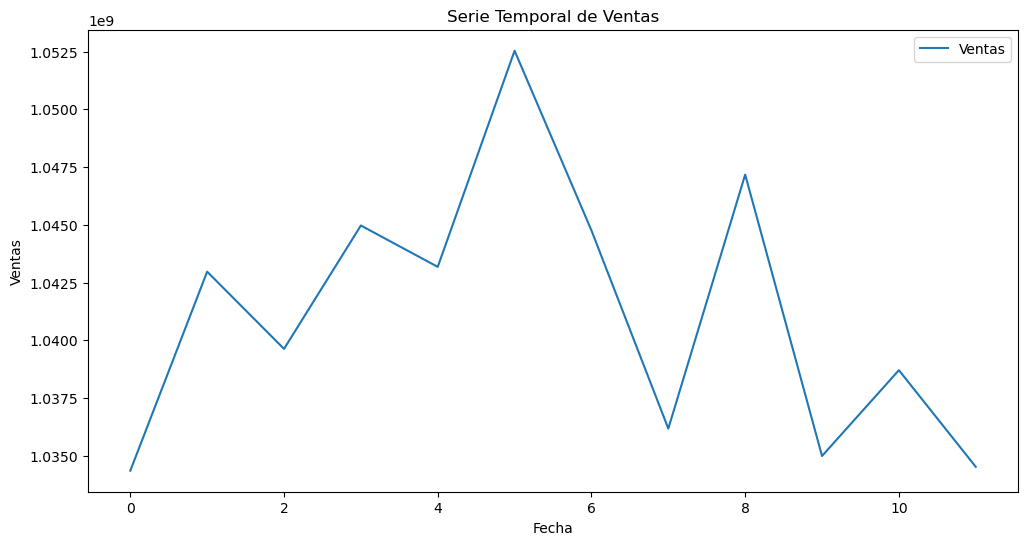

In [535]:
# Proyecciones para esto comparare 3 posible modelos y tomara el que mejor rendimiento me de
#primero tomo el datafrmae original y lo agrupo por dias para ver el valor de ventas de cada dia

datos = result_df['Sales']
print(datos)
# Visualización de datos
plt.figure(figsize=(12, 6))
plt.plot(datos, label='Ventas')
plt.title('Serie Temporal de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()




In [536]:
from statsmodels.tsa.stattools import adfuller
##revision si la serie es estacionaria para usar Arima para la predicción
# Hipótesis nula: La serie tiene una raíz unitaria (no es estacionaria)
resultado_adf = adfuller(result_df['Sales'])

print('Estadística ADF:', resultado_adf[0])
print('Valor p:', resultado_adf[1])

if resultado_adf[1] <= 0.05:
    print('La serie es estacionaria.')
else:
    print('La serie no es estacionaria.')

Estadística ADF: -3.080771469164891
Valor p: 0.02800930053228268
La serie es estacionaria.


C:\Users\User\anaconda3\envs\PF\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


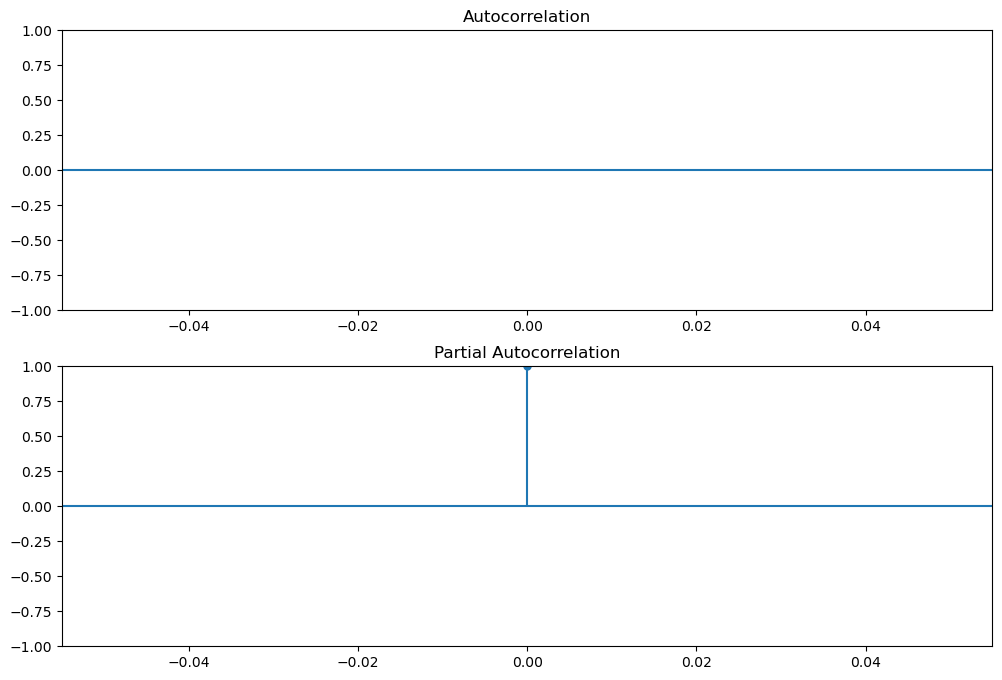

In [537]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# verificación de si la serie temporal sea estacionaria
result_df['Sales_diff'] = result_df['Sales'].diff().dropna()

# Visualizar la autocorrelación y autocorrelación parcial
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Gráfico de autocorrelación (ACF)
plot_acf(result_df['Sales_diff'], lags=5, ax=ax1)

# Gráfico de autocorrelación parcial (PACF)
plot_pacf(result_df['Sales_diff'], lags=5, ax=ax2)

plt.show()


In [538]:
print(result_df.columns)
print(result_df['YearMonth'].dtype)

Index(['index', 'YearMonth', 'Sales', 'cambio_valor', 'cambio_porcentual',
       'Sales_diff'],
      dtype='object')
datetime64[ns]


C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarnin

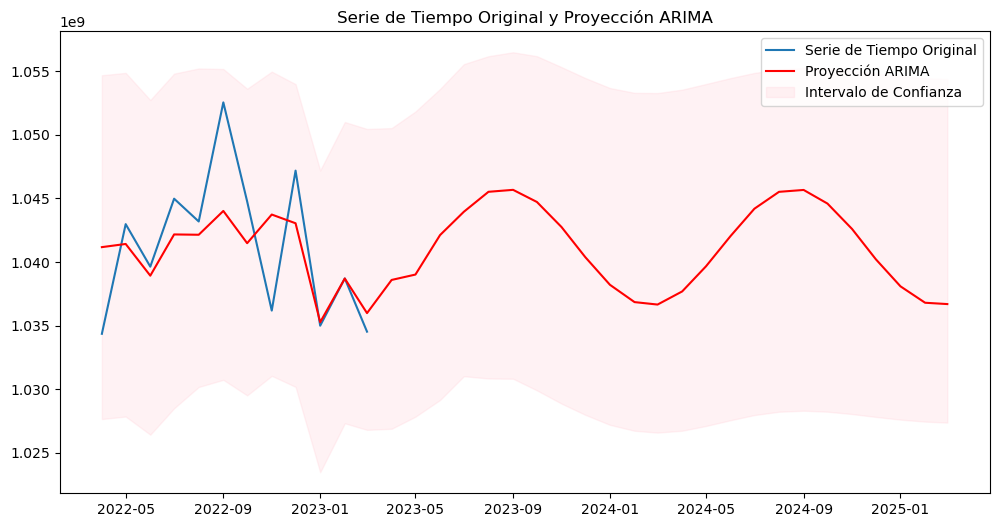

In [539]:
# Configurar la frecuencia de la serie temporal
result_df.index = pd.DatetimeIndex(result_df['YearMonth'], freq='MS')
result_df1 = result_df.set_index('YearMonth')

# Ajustar el modelo ARIMA
p, d, q = 3, 0, 2 # parametros usados
fit_model = ARIMA(result_df1['Sales'], order=(p, d, q))
fit_result = fit_model.fit()

# proyección
forecast_steps = 24  # 2 años, 24 meses
forecast1 = fit_result.get_prediction(end=result_df1.index[-1] + pd.DateOffset(months=forecast_steps), dynamic=False)

# Obtener los intervalos de confianza
forecast_ci1 = forecast1.conf_int()

# Visualizar la serie de tiempo original y la proyección
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df['Sales'], label='Serie de Tiempo Original')
plt.plot(forecast1.predicted_mean.index, forecast1.predicted_mean.values, color='red', label='Proyección ARIMA')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.2, label='Intervalo de Confianza')
plt.title('Serie de Tiempo Original y Proyección ARIMA')
plt.legend()
plt.show()





C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


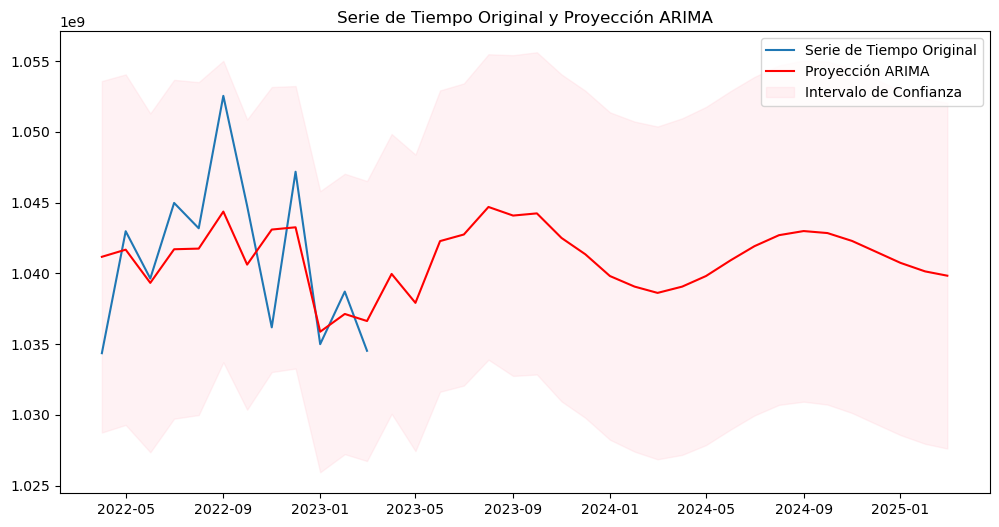

In [540]:
# Configurar la frecuencia de la serie temporal
result_df.index = pd.DatetimeIndex(result_df['YearMonth'], freq='MS')
result_df2 = result_df.set_index('YearMonth')

# Ajustar el modelo ARIMA con otros posibles parametros
p, d, q = 5, 0, 1  
fit_model = ARIMA(result_df2['Sales'], order=(p, d, q))
fit_result = fit_model.fit()

#  proyección 2
forecast_steps = 24  # 2 años, 24 meses
forecast2 = fit_result.get_prediction(end=result_df2.index[-1] + pd.DateOffset(months=forecast_steps), dynamic=False)

# Obtener los intervalos de confianza
forecast_ci = forecast2.conf_int()

# Visualizar la serie de tiempo original y la proyección
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df['Sales'], label='Serie de Tiempo Original')
plt.plot(forecast2.predicted_mean.index, forecast2.predicted_mean.values, color='red', label='Proyección ARIMA')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.2, label='Intervalo de Confianza')
plt.title('Serie de Tiempo Original y Proyección ARIMA')
plt.legend()
plt.show()



C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\PF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


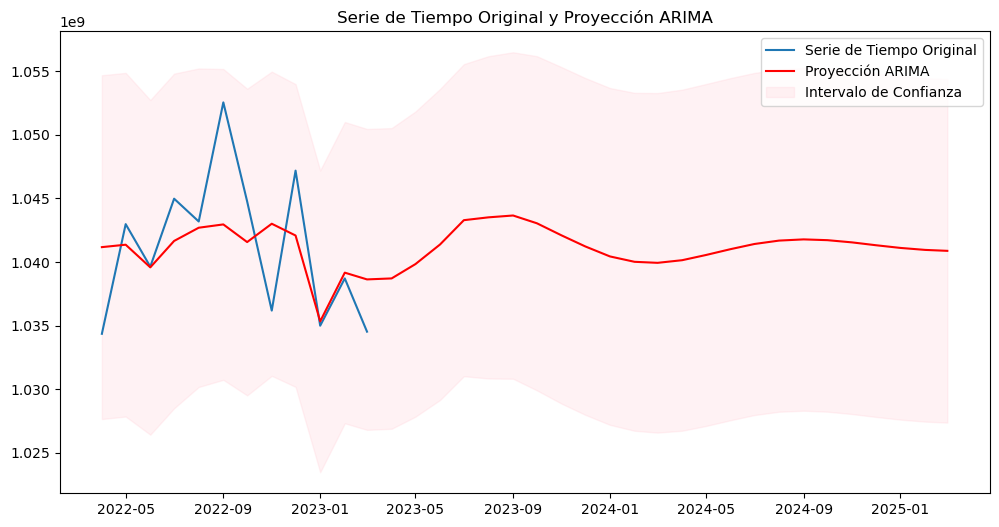

In [541]:
# Configurar la frecuencia de la serie temporal
result_df.index = pd.DatetimeIndex(result_df['YearMonth'], freq='MS')
result_df3 = result_df.set_index('YearMonth')

# Ajustar el modelo ARIMA con otra opción de parametros
p, d, q = 4, 0, 1  # Ajusta según tu modelo
fit_model = ARIMA(result_df3['Sales'], order=(p, d, q))
fit_result = fit_model.fit()

# Realizar la proyección
forecast_steps = 24  # 2 años, 24 meses
forecast3 = fit_result.get_prediction(end=result_df3.index[-1] + pd.DateOffset(months=forecast_steps), dynamic=False)

# Obtener los intervalos de confianza
forecast_ci = forecast3.conf_int()

# Visualizar la serie de tiempo original y la proyección
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df['Sales'], label='Serie de Tiempo Original')
plt.plot(forecast3.predicted_mean.index, forecast3.predicted_mean.values, color='red', label='Proyección ARIMA')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.2, label='Intervalo de Confianza')
plt.title('Serie de Tiempo Original y Proyección ARIMA')
plt.legend()
plt.show()

In [542]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
# Asegúrate de que solo estás tomando las predicciones para los primeros 12 meses
y_pred1 = forecast1.predicted_mean.head(12)
y_pred2 = forecast2.predicted_mean.head(12)
y_pred3 = forecast3.predicted_mean.head(12)

# Asegúrate de que también estás tomando los primeros 12 meses de los valores reales
y_true = result_df3['Sales'].head(12)

# Calcula MSE y MAE para cada conjunto de predicciones
mse1 = mean_squared_error(y_true, y_pred1)
mae1 = mean_absolute_error(y_true, y_pred1)

mse2 = mean_squared_error(y_true, y_pred2)
mae2 = mean_absolute_error(y_true, y_pred2)

mse3 = mean_squared_error(y_true, y_pred3)
mae3 = mean_absolute_error(y_true, y_pred3)

# Imprime los resultados
print('Conjunto 1:')
print(f'MSE: {mse1}')
print(f'MAE: {mae1}')

print('\nConjunto 2:')
print(f'MSE: {mse2}')
print(f'MAE: {mae2}')

print('\nConjunto 3:')
print(f'MSE: {mse3}')
print(f'MAE: {mae3}')

Conjunto 1:
MSE: 18172614183012.824
MAE: 3180140.7296513617

Conjunto 2:
MSE: 17988008836186.098
MAE: 3404210.8723391094

Conjunto 3:
MSE: 21009000876885.336
MAE: 3490970.3753964505


In [543]:
#En resumen, según estas métricas, el Conjunto 1 parece tener un mejor rendimiento en términos de predicciones más cercanas a los valores reales. 
#Sin embargo, ten en cuenta que debes considerar estas métricas en conjunto y también tener en cuenta el contexto del problema. 
#Puede ser útil visualizar las predicciones y los valores reales para tener una comprensión más completa del rendimiento del modelo.

In [544]:
Data['Date'] = pd.to_datetime(Data['Date'])

# Agrupa por mes y suma los valores
df_aggregated_sum = Data.groupby(Data['Date'].dt.to_period('M'))[
    ['Cost USD', 'Financing Costs', 'Anticipation cost', 'Validation Costs', 'Rev Tax cost',
    'Transfer cost', 'Transfer Tax', 'Withholdings assumed', 'Total Costs', 'Commisions', 'Sales']
].sum().reset_index()

# O, si prefieres, puedes calcular el promedio
df_aggregated_mean = Data.groupby(Data['Date'].dt.to_period('M'))[
    ['Cost USD', 'Financing Costs', 'Anticipation cost', 'Validation Costs', 'Rev Tax cost',
    'Transfer cost', 'Transfer Tax', 'Withholdings assumed', 'Total Costs', 'Commisions', 'Sales']
].mean().reset_index()

print(df_aggregated_mean)

       Date     Cost USD  Financing Costs  Anticipation cost  \
0   2022-04 49408750.038     49718809.450       49152631.974   
1   2022-05 49746456.839     49730229.331       49300491.522   
2   2022-06 49387552.324     49871233.635       49492417.616   
3   2022-07 49188250.090     49320976.357       49560300.589   
4   2022-08 49573456.774     50010359.809       49464705.013   
5   2022-09 49348580.071     49207073.972       49414022.011   
6   2022-10 49487750.392     49468682.574       50039476.764   
7   2022-11 49320902.498     49377555.362       49544671.327   
8   2022-12 49246385.655     49291531.993       49571463.098   
9   2023-01 49009689.188     49497237.088       49599287.962   
10  2023-02 49436371.708     49192758.020       49274356.053   
11  2023-03 49154618.084     49258986.627       49365074.256   

    Validation Costs  Rev Tax cost  Transfer cost  Transfer Tax  \
0       49509564.405  49295846.988   49570149.583  49560003.082   
1       49559528.084  49604247.52

In [552]:
print(df_aggregated_sum)

       Date      Cost USD  Financing Costs  Anticipation cost  \
0   2022-04  799927663120     804947525000       795781111652   
1   2022-05  814051019708     813785472773       806753243259   
2   2022-06  802103237295     809958705470       803806354503   
3   2022-07  784405024186     786521609968       790338113496   
4   2022-08  795356540485     802366212775       793611727230   
5   2022-09  773045506820     770828813765       774070654803   
6   2022-10  749788906184     749500009679       758148112445   
7   2022-11  746274575697     747131790185       749660421844   
8   2022-12  727369116120     728035927537       732170509957   
9   2023-01  695790557404     702712274936       704161091190   
10  2023-02  698535932227     695093670818       696246651023   
11  2023-03  686837478483     688295820143       689778182575   

    Validation Costs  Rev Tax cost  Transfer cost  Transfer Tax  \
0       801559847718  798099762735   802540721745  802376449891   
1       810992117570

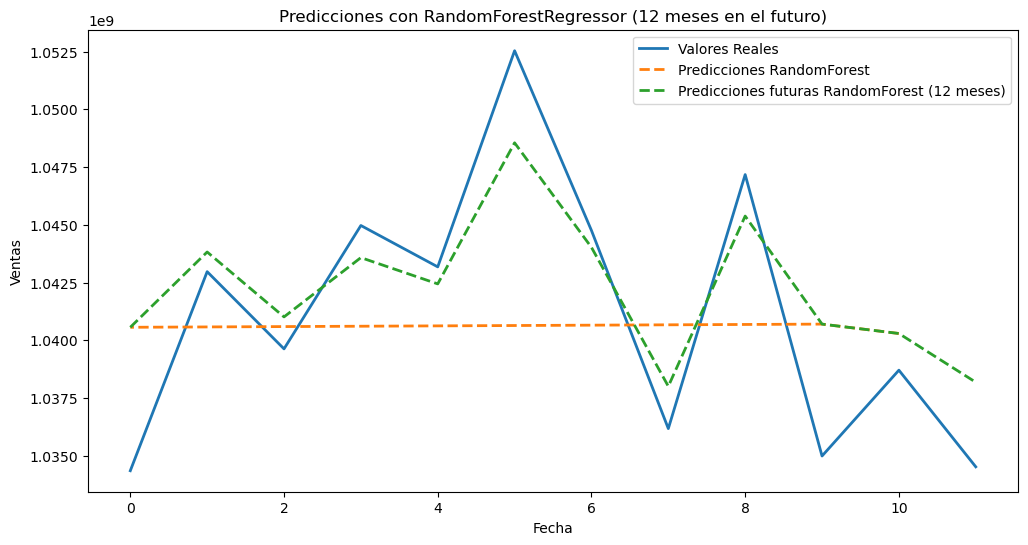

In [553]:
from sklearn.ensemble import RandomForestRegressor
# Supongamos que 'df_aggregated_mean' contiene las variables ['Cost USD', 'Financing Costs', ...] y 'Sales'

# Crear variables independientes (X) y la variable dependiente (y)
X = df_aggregated_mean[['Cost USD', 'Financing Costs', 'Anticipation cost', 'Validation Costs', 'Rev Tax cost',
                         'Transfer cost', 'Transfer Tax', 'Withholdings assumed', 'Total Costs', 'Commisions']]
y = df_aggregated_mean['Sales']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Realizar predicciones para los datos de prueba y futuros
y_pred_rf_test = model_rf.predict(X_test)

# Crear variables independientes para los próximos 12 meses
X_future_12_months = df_aggregated_mean.iloc[-12:][['Cost USD', 'Financing Costs', 'Anticipation cost', 'Validation Costs', 'Rev Tax cost',
                                                     'Transfer cost', 'Transfer Tax', 'Withholdings assumed', 'Total Costs', 'Commisions']]

# Realizar predicciones para los próximos 12 meses
y_pred_rf_future_12_months = model_rf.predict(X_future_12_months)

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df_aggregated_mean.index, df_aggregated_mean['Sales'], label='Valores Reales', linewidth=2)
plt.plot(X_test.index, y_pred_rf_test, label='Predicciones RandomForest', linestyle='--', linewidth=2)
plt.plot(X_future_12_months.index, y_pred_rf_future_12_months, label='Predicciones futuras RandomForest (12 meses)', linestyle='--', linewidth=2)
plt.title('Predicciones con RandomForestRegressor (12 meses en el futuro)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

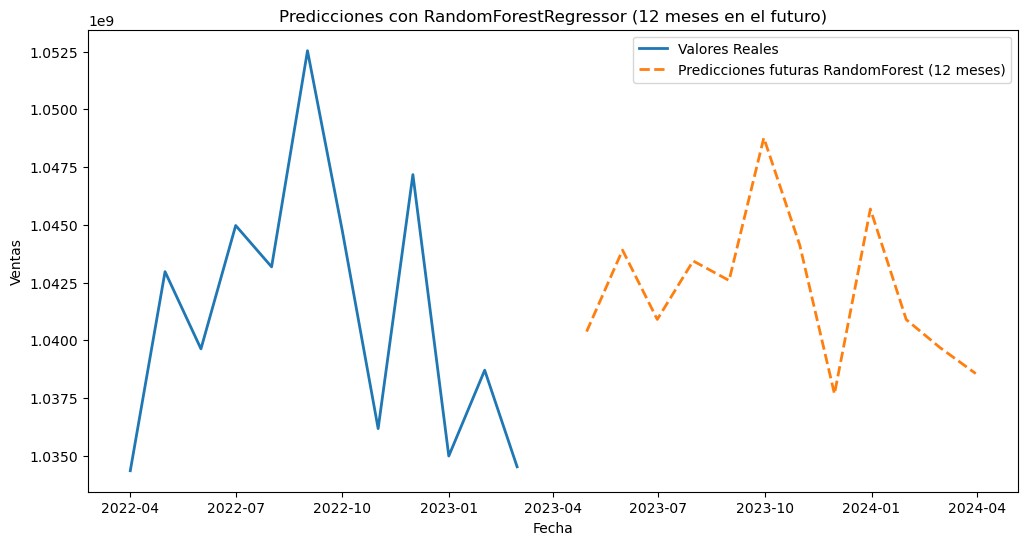

In [557]:
# Supongamos que 'df_aggregated_mean' contiene las variables ['Cost USD', 'Financing Costs', ...] y 'Sales'

# Crear variables independientes (X) y la variable dependiente (y)
X = df_aggregated_mean[['Cost USD', 'Financing Costs', 'Anticipation cost', 'Validation Costs', 'Rev Tax cost',
                         'Transfer cost', 'Transfer Tax', 'Withholdings assumed', 'Commisions']]
y = df_aggregated_mean['Sales']
# Convertir 'Date' a formato de fecha (datetime)
df_aggregated_mean['Date'] = df_aggregated_mean['Date'].dt.to_timestamp()
df_aggregated_mean['Date'] = pd.to_datetime(df_aggregated_mean['Date'])

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Realizar predicciones para los datos de prueba y futuros
y_pred_rf_test = model_rf.predict(X_test)

# Crear variables independientes para los próximos 12 meses
X_future_12_months = df_aggregated_mean.iloc[-12:][['Cost USD', 'Financing Costs', 'Anticipation cost', 'Validation Costs', 'Rev Tax cost',
                                                     'Transfer cost', 'Transfer Tax', 'Withholdings assumed', 'Commisions']]

# Realizar predicciones para los próximos 12 meses
y_pred_rf_future_12_months = model_rf.predict(X_future_12_months)


# Extender las fechas para incluir los próximos 12 meses
max_date_timestamp = df_aggregated_mean['Date'].max()
dates_future_12_months = pd.date_range(start=max_date_timestamp, periods=13, freq='M')[1:]

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df_aggregated_mean['Date'], df_aggregated_mean['Sales'], label='Valores Reales', linewidth=2)

plt.plot(dates_future_12_months, y_pred_rf_future_12_months, label='Predicciones futuras RandomForest (12 meses)', linestyle='--', linewidth=2)
plt.title('Predicciones con RandomForestRegressor (12 meses en el futuro)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()









In [558]:
datal= pd.read_excel('C:/Users/User/Desktop/prueba payu/Datos de mercado.xlsx')
df_additional_features=pd.DataFrame(datal)
df_combined = pd.merge(df_aggregated_mean, df_additional_features, on='Date', how='inner')
print(df_combined)

         Date     Cost USD  Financing Costs  Anticipation cost  \
0  2022-04-01 49408750.038     49718809.450       49152631.974   
1  2022-05-01 49746456.839     49730229.331       49300491.522   
2  2022-06-01 49387552.324     49871233.635       49492417.616   
3  2022-07-01 49188250.090     49320976.357       49560300.589   
4  2022-08-01 49573456.774     50010359.809       49464705.013   
5  2022-09-01 49348580.071     49207073.972       49414022.011   
6  2022-10-01 49487750.392     49468682.574       50039476.764   
7  2022-11-01 49320902.498     49377555.362       49544671.327   
8  2022-12-01 49246385.655     49291531.993       49571463.098   
9  2023-01-01 49009689.188     49497237.088       49599287.962   
10 2023-02-01 49436371.708     49192758.020       49274356.053   
11 2023-03-01 49154618.084     49258986.627       49365074.256   

    Validation Costs  Rev Tax cost  Transfer cost  Transfer Tax  \
0       49509564.405  49295846.988   49570149.583  49560003.082   
1      

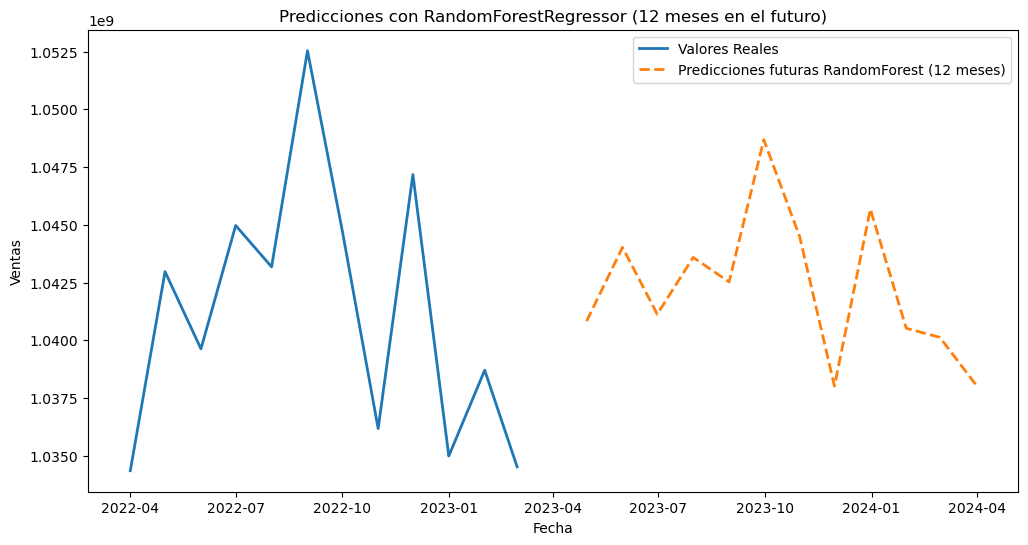

In [559]:
# Crear variables independientes (X) y la variable dependiente (y)
X = df_combined[['Cost USD', 'Financing Costs', 'Anticipation cost', 'Validation Costs', 'Rev Tax cost',
                 'Transfer cost', 'Transfer Tax', 'Withholdings assumed', 'Commisions', 'consumer Price Index', 'unemployment rate', 'US Monthly GDP']]
y = df_combined['Sales']

# Convertir 'Date' a formato de fecha (datetime)
df_combined['Date'] = pd.to_datetime(df_combined['Date'])

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Realizar predicciones para los datos de prueba y futuros
y_pred_rf_test = model_rf.predict(X_test)

# Crear variables independientes para los próximos 12 meses
X_future_12_months = df_combined.iloc[-12:][['Cost USD', 'Financing Costs', 'Anticipation cost', 'Validation Costs', 'Rev Tax cost',
                                             'Transfer cost', 'Transfer Tax', 'Withholdings assumed', 'Commisions','consumer Price Index', 'unemployment rate', 'US Monthly GDP']]

# Realizar predicciones para los próximos 12 meses
y_pred_rf_future_12_months = model_rf.predict(X_future_12_months)

# Extender las fechas para incluir los próximos 12 meses
max_date_timestamp = df_combined['Date'].max()
dates_future_12_months = pd.date_range(start=max_date_timestamp, periods=13, freq='M')[1:]

# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(df_combined['Date'], df_combined['Sales'], label='Valores Reales', linewidth=2)

plt.plot(dates_future_12_months, y_pred_rf_future_12_months, label='Predicciones futuras RandomForest (12 meses)', linestyle='--', linewidth=2)
plt.title('Predicciones con RandomForestRegressor (12 meses en el futuro)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

In [560]:
df_comparison = pd.DataFrame({
    'Fecha': dates_future_12_months,
    'Ventas Reales': df_combined['Sales'].iloc[-12:].values,
    'Ventas Proyectadas': y_pred_rf_future_12_months
})

# Imprimir el DataFrame
print(df_comparison)

        Fecha  Ventas Reales  Ventas Proyectadas
0  2023-04-30 1034354768.163      1040832454.124
1  2023-05-31 1042972672.508      1044027216.067
2  2023-06-30 1039630025.602      1041130596.844
3  2023-07-31 1044971422.117      1043590547.949
4  2023-08-31 1043180325.251      1042528125.647
5  2023-09-30 1052538185.814      1048686406.069
6  2023-10-31 1044756459.951      1044480804.674
7  2023-11-30 1036178857.317      1038017785.034
8  2023-12-31 1047175390.280      1045680981.018
9  2024-01-31 1034991819.799      1040521825.164
10 2024-02-29 1038707406.033      1040128987.484
11 2024-03-31 1034524127.425      1038086159.135


In [561]:
# Calcular las ventas promedio mensuales

print(df_aggregated_mean['Sales'])
monthly_avg_sales = (df_aggregated_mean['Sales'])

0    1034354768.163
1    1042972672.508
2    1039630025.602
3    1044971422.117
4    1043180325.251
5    1052538185.814
6    1044756459.951
7    1036178857.317
8    1047175390.280
9    1034991819.799
10   1038707406.033
11   1034524127.425
Name: Sales, dtype: float64


In [562]:
# Supongamos que 'df_aggregated_mean' contiene las variables ['Date', 'Sales']

# Convertir 'Date' a formato de fecha (datetime)
df_aggregated_mean['Date'] = pd.to_datetime(df_aggregated_mean['Date'])
# Supongamos que 'df_aggregated_mean' contiene las variables ['Date', 'Sales']

print(df_aggregated_mean['Sales'])

0    1034354768.163
1    1042972672.508
2    1039630025.602
3    1044971422.117
4    1043180325.251
5    1052538185.814
6    1044756459.951
7    1036178857.317
8    1047175390.280
9    1034991819.799
10   1038707406.033
11   1034524127.425
Name: Sales, dtype: float64


In [563]:
# Supongamos que 'df_aggregated_mean' contiene las variables ['Date', 'Sales']
# y 'df_comparison' es el DataFrame que contiene la comparación de ventas proyectadas y reales

# Convertir 'Date' a formato de fecha (datetime)
df_aggregated_mean['Date'] = pd.to_datetime(df_aggregated_mean['Date'])

# Calcular las ventas mensuales para cada mes del DataFrame original
df_aggregated_mean['Month'] = df_aggregated_mean['Date'].dt.month
monthly_sales_actual = df_aggregated_mean.groupby('Month')['Sales'].mean()

# Calcular las ventas mensuales proyectadas para los 12 meses
df_comparison['Month'] = df_comparison['Fecha'].dt.month
monthly_sales_projected = df_comparison.groupby('Month')['Ventas Proyectadas'].mean()

# Calcular la variación porcentual anual
annual_variation_percentage = ((monthly_sales_projected - monthly_sales_actual) / monthly_sales_actual) * 100

# Crear un DataFrame con los resultados
df_variation = pd.DataFrame({
    'Month': annual_variation_percentage.index,
    'Variacion % Anual': annual_variation_percentage.values
})

# Imprimir o mostrar el DataFrame con la variación porcentual anual
print(df_variation)

    Month  Variacion % Anual
0       1              0.534
1       2              0.137
2       3              0.344
3       4              0.626
4       5              0.101
5       6              0.144
6       7             -0.132
7       8             -0.063
8       9             -0.366
9      10             -0.026
10     11              0.177
11     12             -0.143


In [564]:

# Calcular Margin
Data['Margin'] = ((Data['Sales'] - Data['Total Costs'])/Data['Sales'])*100
print(Data['Margin'])

0          61.689
1          60.710
2          77.475
3          68.119
4          58.326
           ...   
183798     79.974
183799     12.683
183800   -156.083
183801     35.908
183802     53.655
Name: Margin, Length: 183803, dtype: float64


In [565]:
# Calcular el %GM

# Calcular Margin
Data['% GM'] = ((Data['Sales'] - Data['Total Costs'])/Data['Sales'])*100
print(Data['% GM'])

0          61.689
1          60.710
2          77.475
3          68.119
4          58.326
           ...   
183798     79.974
183799     12.683
183800   -156.083
183801     35.908
183802     53.655
Name: % GM, Length: 183803, dtype: float64


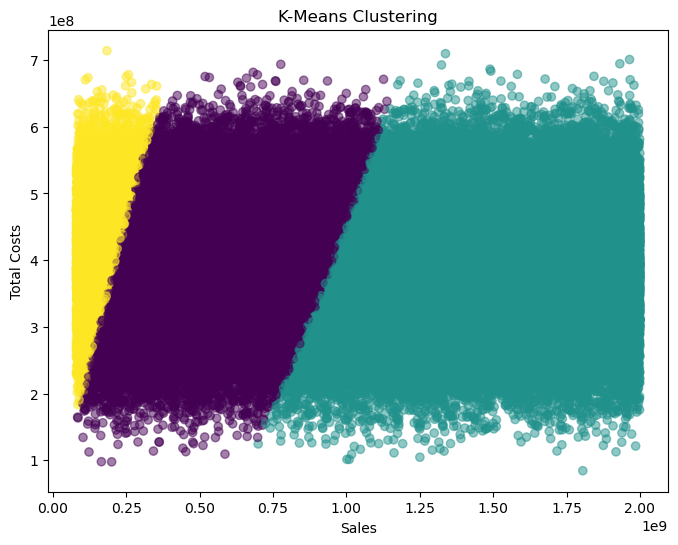

                 Sales   Total Costs   Margin     % GM
cluster                                               
0        582664891.266 397997753.535   20.078   20.078
1       1473216691.038 389915672.174   72.449   72.449
2        154593992.868 422402735.077 -196.517 -196.517


<Figure size 800x600 with 0 Axes>

In [575]:
##segmentacion haciendo k-means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Seleccionar las variables para clustering
variables_cluster = ['Sales', 'Total Costs', 'Margin', '% GM']

# Crear una matriz de características para el clustering
X = Data[variables_cluster]

# Normalizar los datos
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Seleccionar el número de clústeres (puedes ajustar este valor)
k = 3

# Aplicar K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
Data['cluster'] = kmeans.fit_predict(X_normalized)

# Visualizar resultados (puedes adaptar esta visualización según tus necesidades)
plt.scatter(Data['Sales'], Data['Total Costs'], c=Data['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Sales')
plt.ylabel('Total Costs')
plt.title('K-Means Clustering')
plt.show()
plt.savefig('C:/Users/User/Desktop/prueba payu/imagensegmentacion.jpg',transparent=True)
# Visualizar la segmentación en función de otras variables
segmentation_summary = Data.groupby('cluster')[variables_cluster].mean()
print(segmentation_summary)

In [567]:
# Agregar la columna 'cluster' al DataFrame original 'Data'
Data['segmento'] = kmeans.labels_

# Verificar el resultado
print(Data.head())

   identificador cliente nombre cliente       Date  Cost USD  Financing Costs  \
0              510555613      AAAABBB-1 2022-05-01  35594973         80542247   
1              510555613      AAAABBB-1 2022-06-01  49072039          9524087   
2              510555613      AAAABBB-1 2022-09-01  65343219         20324356   
3              510555613      AAAABBB-1 2022-11-01   6366652         69485745   
4              510555617      AAAABBB-2 2022-04-01  87555273         15368780   

   Anticipation cost  Validation Costs  Rev Tax cost  Transfer cost  \
0           29805489          13867748      76910407       76742389   
1            4879928          58733743      93361384       67623535   
2            6717897          35951576      78200708       38362249   
3           62750641          15412979      56897582       93168936   
4           27122598          50924743      20665118       91794016   

   Transfer Tax  Withholdings assumed  Total Costs       Sales    Commisions  \
0     

In [572]:
# Supongamos que 'kmeans' es tu modelo K-Means entrenado
num_clusters = kmeans.n_clusters
print("Número de clusters:", num_clusters)


Número de clusters: 3


In [ ]:
ruta_del_archivo_csv = 'C:/Users/User/Desktop/prueba payu/dataframeT.csv'

# Exporta el DataFrame a un archivo CSV
Data.to_csv(ruta_del_archivo_csv, index=False)